In [3]:
from core.strategies import BacktestManager
from core.signals import OECDUSLEIHP

# signal = OECDUSLEIHP.from_fred_data()
bt = BacktestManager.from_universe(start="2005-1-1")
bt.EqualWeight()
bt.MinCorr()
bt.values
# bt.RegimeRotation(signal=signal)
# bt.RegimeRotationMinCorr(signal=signal)
# bt.RegimeRotationMinCorr(signal=signal, span=21*3)
# bt.EqualWeight()
# bt.MinCorr()
# bt.MinVol(span=21*12)
# bt.Momentum()
# bt.values

[*********************100%***********************]  11 of 11 completed


,EqualWeight,MinCorr
2005-01-03,9900.000100,9900.000000
2005-01-04,9795.817654,9799.464959
2005-01-05,9733.719765,9728.557371
2005-01-06,9779.287099,9786.415772
2005-01-07,9767.743373,9786.327391
...,...,...
2023-05-16,48923.875024,59366.229604
2023-05-17,49455.143775,59861.868580
2023-05-18,49755.681456,60176.332878
2023-05-19,49712.456801,60270.136864


In [8]:
bt.strategies["MinCorr"].data.weights

""


[*********************100%***********************]  2 of 2 completed


<AxesSubplot:>

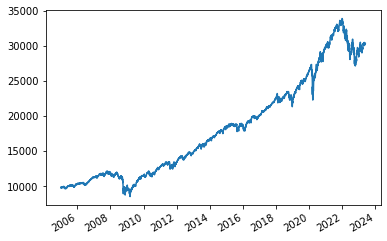

In [3]:
"""ROBERT"""
from typing import Optional, Callable
import pandas as pd


class DataStore(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value

    @property
    def value(self) -> pd.Series:
        return pd.Series(self["value"])

    @property
    def cash(self) -> pd.Series:
        return pd.Series(self["cash"])

    @property
    def weights(self) -> pd.DataFrame:
        return pd.DataFrame(self["weights"]).T
    
    @property
    def allocations(self) -> pd.DataFrame:
        return pd.DataFrame(self["allocations"]).T


    @property
    def trades(self) -> pd.DataFrame:
        return pd.DataFrame(self["trades"]).T

class Strategy:
    """base strategy"""

    def __init__(
        self,
        prices: pd.DataFrame,
        rebalance: Callable,
        frequency: str = "M",
        start: Optional[str] = None,
        end: Optional[str] = None,
        initial_investment: float = 10_000.0,
        commission: int = 10,
        shares_frac: Optional[int] = None,
    ) -> None:
        self.total_prices: pd.DataFrame = prices.ffill()
        self.date: pd.Timestamp = pd.Timestamp(str(self.total_prices.index[0]))
        self.commission = commission
        self.rebalance: Callable = rebalance
        self.shares_frac = shares_frac
        self.cash = initial_investment
        self.shares = pd.Series(dtype=float)

        self.data = DataStore()

        self.simulate(
            start=start or str(self.total_prices.index[0]),
            end=end or str(self.total_prices.index[-1]),
            freq=frequency,
        )

    ################################################################################

    @property
    def prices(self) -> pd.DataFrame:
        """prices"""
        if self.date is None:
            return pd.DataFrame()
        return self.total_prices[self.total_prices.index < self.date].dropna(
            how="all", axis=1
        )

    @property
    def value(self) -> float:
        return self.capitals.sum() + self.cash

    @property
    def capitals(self) -> pd.Series:
        return self.shares.multiply(self.total_prices.loc[self.date])

    @property
    def weights(self) -> pd.Series:
        return self.capitals.divide(self.value)

    ################################################################################

    def simulate(self, start: str, end: str, freq: str = "M") -> None:
        allocations = pd.Series(dtype=float)
        rebalance_dates = pd.DatetimeIndex([start]).append(
            pd.date_range(start=start, end=end, freq=freq, inclusive="neither")
        )
        rebalance_dates = rebalance_dates.append(pd.DatetimeIndex([end]))

        for self.date in self.total_prices.loc[start:end].index:
            if self.date >= rebalance_dates[0]:
                allocations = self.rebalance(strategy=self)
                if not isinstance(allocations, pd.Series):
                    allocations = pd.Series(allocations, dtype=float)
                if not allocations.empty:
                    self.data["allocations"][self.date] = allocations
                    rebalance_dates = rebalance_dates[1:]

                    # Make trades here
                    target_capials = self.value * allocations
                    target_shares = target_capials.divide(
                        self.total_prices.loc[self.date]
                    )
                    if self.shares_frac is not None:
                        target_shares = target_shares.round(self.shares_frac)

                    trade_shares = target_shares.subtract(self.shares, fill_value=0)
                    trade_shares = trade_shares[trade_shares != 0]
                    self.data["trades"][self.date] = trade_shares
                    trade_capitals = trade_shares.multiply(
                        self.total_prices.loc[self.date]
                    )
                    trade_capitals += trade_capitals.multiply(self.commission / 1_000)
                    self.cash -= trade_capitals.sum()
                    self.shares = target_shares
            self.data["value"][self.date] = self.value
            self.data["shares"][self.date] = self.shares
            self.data["cash"][self.date] = self.cash


import yfinance as yf
from core.portfolios import Optimizer


def func(strategy: Strategy) -> pd.Series:
    return Optimizer.from_prices(prices=strategy.prices).uniform_allocation()


p = yf.download("SPY, AGG")["Adj Close"].dropna().round(4)
strategy = Strategy(prices=p, rebalance=func, start="2005-1-1", shares_frac=0)
strategy.data.value.plot()


In [4]:
strategy.data.trades

,AGG,SPY
2005-01-03,86.0,59.0
2005-01-31,-2.0,NaN
2005-02-28,1.0,-1.0
2005-03-31,NaN,1.0
2005-05-02,-1.0,1.0
...,...,...
2023-01-31,2.0,-1.0
2023-02-28,1.0,NaN
2023-03-31,NaN,NaN
2023-05-01,2.0,NaN


In [1]:
start = "2022-1-28"
end="2022-3-5"
import pandas as pd
pd.date_range(start=start, end=end, freq="M", inclusive="right").append(pd.DatetimeIndex([end])).insert(0, pd.DatetimeIndex([start]))

: 

: 

In [ ]:
import database as db
import pandas as pd
from datetime import date
from sqlalchemy import func

db.create_all()
today = date(2017,1,1)


from sqlalchemy import select

with db.engine.connect() as conn:
    
    subquery = select(
        func.max(db.UniverseInvestable.date),
    ).\
        where(db.UniverseInvestable.date < today).scalar_subquery()

    statement = select(
        db.UniverseInvestable.date,
        db.Investable.ticker,
        db.Investable.name,
    ).join(db.Investable, db.Investable.id == db.UniverseInvestable.investable_id).\
        where(db.UniverseInvestable.date == subquery).\
        order_by(db.UniverseInvestable.date)

    data = pd.read_sql(
        sql=statement, con=conn, parse_dates=["date"], index_col=["date"]
    )

    print(data.loc["2018":])
    conn.close()

In [ ]:

import pandas as pd
import yfinance as yf
from scipy.stats import percentileofscore
from core.analytics.metrics import to_drawdown

def adaptive_moving_average(price: pd.Series, window1: int = 50, window2: int = 200, dd_lookback_window: int = 21 * 6) -> float:
    
    dd = to_drawdown(prices=price.to_frame())
    print(dd.iloc[-1].iloc[0])
    dd.plot()
    ps = percentileofscore(dd.iloc[-dd_lookback_window:, [0]], dd.iloc[-1].iloc[0]) / 100
    
    print(ps)
    pass




prices = yf.download("SPY")["Adj Close"].loc["2018":]

prices.expanding(126).apply(adaptive_moving_average)

In [ ]:
from core import Optimizer
import yfinance as yf


r = Optimizer.from_prices(prices=yf.download("SPY,AGG")["Adj Close"].dropna())

r.minimized_correlation()

In [ ]:
print(r.correlation_matrix)

In [ ]:
from typing import Optional
import pandas as pd
from app.core.strategies import Strategy
from app.core.analytics.features import momentum
from app.core.analytics.metrics import to_ann_volatility


class DualMomentum(Strategy):
    # Objective: balanced growth
    # Type: momentum strategy
    # Invests in: ETFs tracking stocks, bonds, real estate, and gold
    # Rebalancing schedule: monthly
    # Taxation: 50% short-term capital gains
    # Minimum account size: $5,000
    def rebalance(self) -> Optional[pd.Series]:
        single_weight = 1 / (len(self.reb_prices.columns) - 1)
        safe = to_ann_volatility(self.reb_prices.iloc[-252:]).idxmin()
        mome_1y = momentum(self.reb_prices, months=6).iloc[-1]
        safe_mome = mome_1y.loc[safe]
        weights = {}
        for asset in self.reb_prices:
            if asset == safe:
                continue
            if mome_1y.loc[asset] > safe_mome:
                weights.update({asset: single_weight})
            else:
                if safe in weights.keys():
                    weights.update({safe: weights[safe] + single_weight})
                else:
                    weights.update({safe: single_weight})
        return pd.Series(weights)


import yfinance as yf

prices = yf.download("SPY, VNQ, XLK, XLU, XLB, XLV, XLY, XLG, BIL, AGG, TLT")[
    "Adj Close"
]

strategy = DualMomentum(prices=prices).simulate("2015-1-1")

strategy.value.plot()


In [ ]:
from app.core.portfolios import Optimizer
from app.core.strategies import Strategy


class MaxSharpe(Strategy):
    def rebalance(self):
        prices = self.reb_prices.iloc[-252:]
        opt = Optimizer.from_prices(prices)
        return opt.maximized_sharpe_ratio()


import yfinance as yf

prices = yf.download("SPY, VNQ, XLK, XLU, XLB, XLV, XLY, XLG, BIL, AGG, TLT")[
    "Adj Close"
]

prices


In [ ]:
test = prices.copy()
test[~test.isnull()] = 1
test

In [ ]:
from app.core.strategies import HierarchicalEqualRiskContribution
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]

strategy = HierarchicalEqualRiskContribution(prices=prices.dropna()).simulate()

strategy.value

In [ ]:
from src import database as db

with db.SessionContext() as session:
    for (source,) in session.query(db.models.Meta.source).distinct():
        print(source)
        if source == "YAHOO":
            import yfinance as yf

            for meta in (
                session.query(db.models.Meta)
                .filter(db.models.Meta.source == source)
                .all()
            ):
                data = yf.download(
                    tickers=meta.code, start="1980-1-1", progress=False, actions=True
                ).reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = data.dividends.divide(
                        data.close.shift(1)
                    ).fillna(0)
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)

        elif source == "NAVER":
            import pandas_datareader as pdr

            for meta in (
                session.query(db.models.Meta)
                .filter(db.models.Meta.source == source)
                .all()
            ):
                data = pdr.DataReader(
                    name=meta.code, data_source="naver", start="1980-1-1"
                ).astype(float)
                data = data.reset_index()
                data.columns = data.columns.str.lower()
                data.columns = data.columns.str.replace(" ", "_")
                data["pri_return"] = (
                    data.close.divide(data.close.shift(1)).subtract(1).fillna(0)
                )
                if "dividends" in data.columns:
                    data["dvd_return"] = data.dividends.divide(
                        data.close.shift(1)
                    ).fillna(0)
                else:
                    data["dvd_return"] = 0
                data["tot_return"] = data["pri_return"].add(data["dvd_return"])
                data = data.assign(meta_id=meta.meta_id)
                print(data)
        else:
            data = None


In [ ]:
import pandas as pd

w = pd.read_clipboard(index_col="date")
r = w.stack().astype(float)
r = r.reset_index()
r.columns = ["date", "ticker", "weight"]
r = r[r.weight != 0.0]
r.to_clipboard()


In [ ]:
pd.to_datetime(pd.to_datetime("2022-2-1")).to_pydatetime()


In [ ]:
pd.read_excel(
    config.DATABASE_EXC, sheet_name="tb_meta", parse_dates=["inception_date"]
).sort_values("meta_id")

In [ ]:
import pandas_datareader as pdr
import pandas as pd


def leading_economic_indicator() -> pd.DataFrame:
    """
    Get raw data for leading economic indicator regime.
    """
    tickers = dict(USALOLITONOSTSAM="USLEI")
    data = (
        pdr.DataReader(list(tickers.keys()), "fred", start="1900-01-01")
        .resample("M")
        .last()
    )
    data = data.rename(columns=tickers)
    return data[["USLEI"]]


leading_economic_indicator()


In [ ]:
from src.core import metrics


import pandas as pd

nav = pd.read_clipboard(index_col="date", parse_dates=True)
nav


In [ ]:
metrics.to_max_drawdown(nav).to_clipboard()


In [ ]:
(
    prices / prices.resample("D").last().ffill().shift(1, freq=pd.DateOffset(months=1))
).dropna()

In [ ]:
prices.pct_change(21)


In [ ]:
import pandas as pd

pri_returns = prices.pct_change()
latest_date = pri_returns.index[-1]
start_date = latest_date + pd.DateOffset(years=5)
start_date


In [ ]:
from src import db


db.create_all()


In [ ]:
import pandas as pd

pr_date = prices.index[-1] - pd.DateOffset(years=1)

prices.iloc[-1] / prices.iloc[prices.index.get_loc(pr_date)] - 1

In [ ]:
import pandas_datareader as pdr


price = pdr.DataReader("329200", "naver", start="2021-4-1")
price.to_csv("329200.csv")

In [ ]:
import json

import pandas as pd
from sec_api import QueryApi
from sec_api import ExtractorApi
from src.config import EDGAR_API

queryApi = QueryApi(api_key=EDGAR_API)

query = {
    "query": {
        "query_string": {
            "query": "ticker:TSLA",
        }
    },
    "from": "200",
    "size": "300",
    "sort": [{"filedAt": {"order": "desc"}}],
}

response = queryApi.get_filings(query)


metadata = pd.DataFrame.from_records(response["filings"])

print(metadata)


# extractorApi = ExtractorApi(EDGAR_API)


# sections_10_k = {
#     "1": "Business",
#     "1A": "Risk Factors",
#     "1B": "Unresolved Staff Comments",
#     "2": "Properties",
#     "3": "Legal Proceedings",
#     "4": "Mine Safety Disclosures",
#     "5": "Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities",
#     "6": "Selected Financial Data (prior to February 2021)",
#     "7": "Management’s Discussion and Analysis of Financial Condition and Results of Operations",
#     "7A": "Quantitative and Qualitative Disclosures about Market Risk",
#     "8": "Financial Statements and Supplementary Data",
#     "9": "Changes in and Disagreements with Accountants on Accounting and Financial Disclosure",
#     "9A": "Controls and Procedures",
#     "9B": "Other Information",
#     "10": "Directors, Executive Officers and Corporate Governance",
#     "11": "Executive Compensation",
#     "12": "Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters",
#     "13": "Certain Relationships and Related Transactions, and Director Independence",
#     "14": "Principal Accountant Fees and Services",
# }


# for id, f in enumerate(response["filings"]):
#     if f["formType"] == "10-K":
#         url_10k = f["linkToFilingDetails"]

#         out = {}

#         for sec, des in sections_10_k.items():
#             out[des] = extractorApi.get_section(url_10k, sec, "text")

#         filename = f"{id}.json"

#         with open(filename, "w") as f:
#             json.dump(out, f)

In [ ]:
metadata.to_csv("test.csv")

In [ ]:
response["filings"][0]["linkToTxt"]

In [ ]:
# 8-K example
url_8k = "https://www.sec.gov/Archives/edgar/data/66600/000149315222016468/form8-k.htm"

item_1_1_text = extractorApi.get_section(
    response["filings"][0]["linkToTxt"], "1-1", "text"
)
item_1_1_text


In [ ]:
stra = strategy.HierarchicalEqualRiskContribution(prices=prices).simulate(
    start="2015-1-1"
)
stra.value.plot()
# weights_bm = prices.notna().divide(prices.notna().sum(axis=1), axis=0)
# metrics.to_pri_return(prices=prices).multiply(weights_bm).sum(axis=1).loc["2015-1-1":].add(1).cumprod().multiply(1000).plot()
stra.analytics()

In [ ]:
from src import db


with db.SessionContext() as session:
    query = session.query(db.models.Meta)

    result = list(record.to_dict() for record in query.all())

print(result)

In [ ]:
import pandas as pd

pd.DataFrame(result)


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# create line chart trace
line_trace = go.Scatter(
    x=stra.value.index, y=stra.value.values, mode="lines", name=stra.value.name
)

# create stacked bar chart traces
bar_traces = []
for col in stra.allocations.columns:
    trace = go.Bar(x=stra.allocations.index, y=stra.allocations[col] * 100, name=col)
    bar_traces.append(trace)

# create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# add line chart to the first subplot with its own legend
fig.add_trace(line_trace, row=1, col=1)
fig.update_traces(showlegend=True, row=1, col=1)

# add stacked bar chart to the second subplot with its own legend
for trace in bar_traces:
    fig.add_trace(trace, row=2, col=1)
    fig.update_traces(showlegend=True, row=2, col=1)

# update chart layout and style
fig.update_layout(
    title="My Beautiful Subplots",
    xaxis_title="Date",
    yaxis_title="Values",
    template="plotly_dark",
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        x=0.5,
        y=1.2,
        orientation="h",
        xanchor="center",
        yanchor="bottom",
        bordercolor="white",
        borderwidth=1,
        bgcolor="white",
        font=dict(size=12),
    ),
    font=dict(family="Arial", size=12, color="black"),
    barmode="stack",
    # add legends for subplots
    annotations=[
        dict(
            x=0.5,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Line Chart</b>",
            font=dict(size=14),
            align="center",
        ),
        dict(
            x=0.5,
            y=0.6,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<b>Stacked Bar Chart</b>",
            font=dict(size=14),
            align="center",
        ),
    ],
)

# show the chart
fig.show()

In [ ]:
from src.core.portfolios import Optimizer
import yfinance as yf

prices = yf.download("SPY, AGG, GSG, TLT")["Adj Close"]
opt = Optimizer.from_prices(prices=prices)
opt.hierarchical_equal_risk_contribution()


In [ ]:
opt.hierarchical_risk_parity()


In [ ]:
opt.maximized_sharpe_ratio()
